## Exercise 1

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

# 1.
bankDf = pd.read_csv('bank.csv', delimiter=';')
bankDf.y = bankDf.y.map({'yes': 1, 'no': 0})
bankDf = pd.get_dummies(bankDf)

In [23]:
# 2.
checkNA = bankDf.isna().any()
print(checkNA.sum())
# We have no NA values so we dont need to drop

0


In [57]:
# 3.
df_train = bankDf.sample(frac = 0.8, random_state = 3116)
df_train.insert(0, 'y', df_train.pop('y'))

df_test = bankDf.drop(df_train.index)
df_test.insert(0, 'y', df_test.pop('y'))


In [58]:
# 4.
df_n_train = (df_train - df_train.mean()) / df_train.std() 
df_n_train.y = df_train.y

df_n_test = (df_test - df_test.mean()) / df_test.std() 
df_n_test.y = df_test.y


In [103]:
# 5
# My functions from ex04 reused here with some minor changes.
def learn_logreg_GA(train, test, mu, n):
    x_test = np.delete(test, 0, 1)
    y_test = test[:, 0].reshape(np.shape(test)[0], 1)
    betas = np.zeros((np.shape(train)[1]-1, 1))
    log_lh = []
    log_ls = []

    for i in range(0, n):
        np.random.shuffle(train)
        x_train = np.delete(train, 0, 1)
        y_train = train[:, 0].reshape(np.shape(train)[0], 1)
        xTrain = np.array_split(x_train, 5)
        yTrain = np.array_split(y_train, 5)
        for j in range(0, len(xTrain)):
            x = xTrain[j]
            y = yTrain[j]
            betas = betas + (mu * d_loglikelihood(x, y, betas))
        log_lh.append(loglike_func(x_train, y_train, betas))  
        log_ls.append(log_loss(x_test, y_test, betas))
        
    return betas, log_lh, log_ls

def loglike_func(x_train, y_train, betas):
    return np.sum(y_train * (x_train @ betas) - np.log(1 + np.exp(x_train @ betas)))

def d_loglikelihood(x_train, y_train, betas):
    return x_train.T @ (y_train - (1 / (1 + np.exp((-x_train) @ betas))))

def dd_loglikelihood(x_train, betas):
    temp = np.diag(((1 / (1 + np.exp((-x_train) @ betas))) *
                    (1 - (1 / (1 + np.exp((-x_train) @ betas))))).flatten())
    return x_train.T @ temp @ x_train

def log_loss(x_train, y_train, betas):
    return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) + 
                              (1 - y_train).T @ np.log(1 - (1 / (1 + np.exp((-x_train) @ betas)))))
def calc_aic(x_train, betas):
    trainX = np.delete(x_train, 0, 1)
    trainY = x_train[:,0].reshape(np.shape(x_train)[0],1)
    aic = -2 * loglike_func(trainX, trainY, betas) + 2*len(betas) 
    return aic

<ipython-input-103-ab0343876e37>:37: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) +


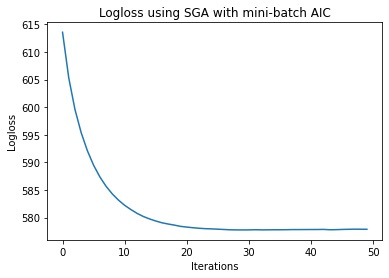

Min AIC :  4575.109243557328  at  49  params


In [104]:
# 6.
mu = 0.00012
n = 50

train = df_n_train.to_numpy()
test = df_n_test.to_numpy()
params = np.shape(train)[1] - 1
trains, tests, aicList, betas = [], [], [], []

for b in range(1, params):
    beta, lossTrList, lossTeList = learn_logreg_GA(train, test, mu, n)
    trains.append(lossTrList)
    tests.append(lossTeList)
    betas.append(beta)
    cur_aic = calc_aic(train, beta)
    aicList.append(cur_aic)
    train = np.delete(train, 1, 1)
    test = np.delete(test, 1, 1)
    
min_p = params - aicList.index(min(aicList))
lossTrList = trains[aicList.index(min(aicList))]
lossTeList = tests[aicList.index(min(aicList))]

# 7.
plt.plot(np.arange(len(lossTeList)), lossTeList)
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Logloss using SGA with mini-batch AIC')
plt.show()

print('Min AIC : ', min(aicList), ' at ', min_p, ' params')

## Exercise 2

In [105]:
# 2.
# Reusing previous functions with changes to handle KFold

def learn_logreg_batch(train, test, mu, n, lmb, batch):
    x_test = np.delete(test, 0, 1)
    y_test = test[:,0].reshape(np.shape(test)[0],1)
    betas = np.zeros((np.shape(train)[1]-1, 1))
    trainLoss, testLoss, accuracy = [], [], []
    
    for i in range(0, n):
        np.random.shuffle(train)
        x_train = np.delete(train, 0, 1)
        y_train = train[:,0].reshape(np.shape(train)[0], 1)
        xTrain = np.array_split(x_train, batch)
        yTrain = np.array_split(y_train, batch)
        for j in range(0, len(xTrain)):
            x = xTrain[j]
            y = yTrain[j]
            betas = betas + mu * d_loglikelihood(x, y, betas, lmb)
        trainLoss.append(log_loss(x_train, y_train, betas, lmb))  
        testLoss.append(log_loss(x_test, y_test, betas, lmb))
    accuracy = calcAccuracy(x_train, y_train, betas)
    return betas, trainLoss, testLoss, accuracy


def kfold(train, mu, n, lmb, k, batch):
    xTrain = np.array_split(train, k)
    foldList = []
    for i in range(k):
        temp = xTrain[i]
        tempTrain = np.vstack(np.delete(xTrain, i))
        betas, trainLoss, testLoss, accuFold = learn_logreg_batch(tempTrain, temp, mu, n, lmb, batch)
        foldList.append(accuFold)
    foldMean = np.mean(foldList)
    return betas, foldMean

def log_loss(x_train, y_train, betas, lmb):
    return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) + 
                          (1 - y_train).T @ np.log(1 - (1 / (1 + np.exp(-x_train @ betas)))) + lmb * betas.T @ betas)

def d_loglikelihood(x_train, y_train, betas, lmb):
    return x_train.T @ (y_train - (1 / (1 + np.exp(-x_train @ betas)))) - 2 * lmb * betas

def calcAccuracy(x_train, y_train, betas):
    return np.sum(np.round(y_train) == np.round(1 / (1 + np.exp(-x_train @ betas)))) / len(y_train)

In [106]:
train = df_n_train.to_numpy()
test = df_n_test.to_numpy()

# 1.
accuList , resList = [], []
b_size, n = 50, 50
lmb = np.arange(1e-6, 1e-5, (1e-5 - 1e-6) / 5)
alpha = np.arange(1e-7, 1e-5, (1e-5 - 1e-7) / 5)

for i in range(len(alpha)):
    for j in range(len(lmb)):
        betas, foldMean = kfold(train, alpha[i], n, lmb[j], 5, b_size)
        resList.append([alpha[i], lmb[i], foldMean, betas])
        accuList.append(foldMean)
mAlpha, mLmb, mAccu, mBeta = resList[accuList.index(max(accuList))]
print(mAccu * 100, '% Accuracy reached at (Alpha, lambda) = (', mAlpha, ',', mLmb, ')')


C:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<ipython-input-105-44f1754d7fe3>:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) +


67.22427010267855 % Accuracy reached at (Alpha, lambda) = ( 8.020000000000001e-06 , 8.200000000000001e-06 )


Text(0.5, 0, 'Accuracy')

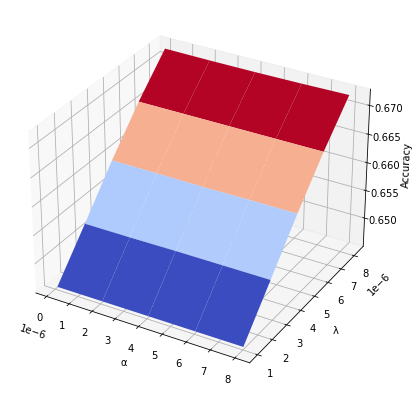

In [90]:
# 3.
pAlpha, pLmb = np.meshgrid(alpha, lmb)
fig = plt.figure(figsize=(15, 7))
axes = plt.axes(projection='3d')

axes.plot_surface(pAlpha, pLmb, np.array(accuList).reshape(len(alpha), len(lmb)), cmap= 'coolwarm') 
axes.set_xlabel('α')
axes.set_ylabel('λ')
axes.set_zlabel('Accuracy')

<ipython-input-105-44f1754d7fe3>:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return -1 * np.asscalar(y_train.T @ np.log(1 / (1 + np.exp((-x_train) @ betas))) +


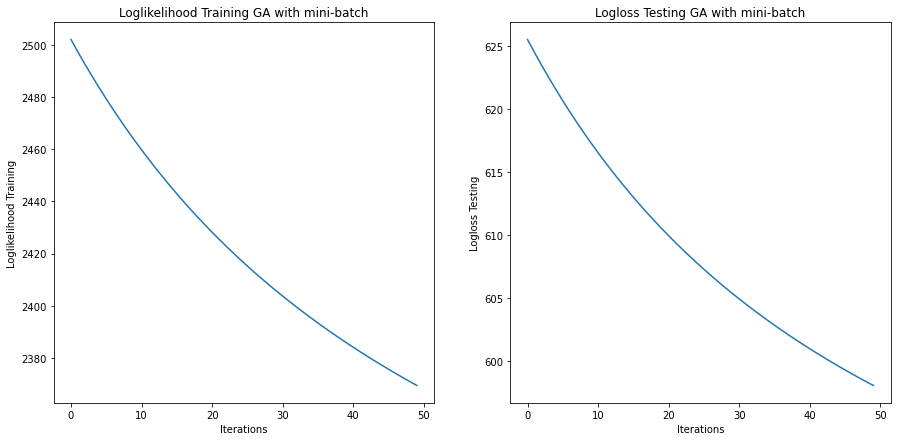

In [107]:
# 4, 5.
betas, trainLoss, testLoss, accu = learn_logreg_batch(train, test, mAlpha, n, mLmb, b_size)
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(trainLoss)), trainLoss)
plt.xlabel('Iterations')
plt.ylabel('Loglikelihood Training')
plt.title('Loglikelihood Training GA with mini-batch')

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(testLoss)), testLoss)
plt.xlabel('Iterations')
plt.ylabel('Logloss Testing')
plt.title('Logloss Testing GA with mini-batch')

plt.show()
